## Experiments with real world data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from factorial_model import FactorialModel
from forward_selection import ForwardSelection

### 5-bit DAC process (Liu and Huang, NIST)

In [3]:
# Load data and take treatment and response variables only
dac = np.loadtxt("data/LIU.DAT", skiprows=25)
dac = dac[:, :6]

In [4]:
# Initialize factorial model
fm = FactorialModel(
    n=dac.shape[0],
    k=dac.shape[1] - 1,
    degree=dac.shape[1] - 1,
    contrast_coding=True,
    beta_seed=0,
)

In [5]:
# Method to evaluate Lasso model
def evaluate_lasso(logistic=False):
    fm.convert_and_split_data(dac[:, 1:], dac[:, 0], is_dummy_coded=True, seed=None)
    fm.fit_lasso(logistic)
    fm.predict()
    fm.compute_mse()
    fm.compute_r2()

In [6]:
# Method to evaluate forward selection
def evaluate_forward_selection(T_test, y_test, logistic=False):
    fs.forward_selection(logistic)
    fs.predict(T_test)
    fs.compute_mse(y_test)
    fs.compute_r2()

In [7]:
# Evaluate two models for NUM_TRIALS
NUM_TRIALS = 100
lasso_mses = []
fs_mses = []
lasso_r2s = []
fs_r2s = []
lasso_betas = []
fs_betas = []
lasso_expected_outcomes = []
fs_expected_outcomes = []

for i in range(NUM_TRIALS):
    evaluate_lasso(logistic=False)
    lasso_mses.append(fm.mse)
    lasso_r2s.append(fm.r2)
    lasso_betas.append(fm.beta_hat)
    lasso_expected_outcomes.append(fm.expected_outcomes)

    fs = ForwardSelection(fm.T_train, fm.y_train, fm.k, strong_heredity=False)
    evaluate_forward_selection(fm.T_test, fm.y_test, logistic=False)
    fs_mses.append(fs.mse)
    fs_r2s.append(fs.r2)
    fs_betas.append(fs.results.params)
    beta_mask = fm.pf.fit_transform(fm.pf.powers_)
    fs_expected_outcome = beta_mask @ fs.results.params
    fs_expected_outcomes.append(fs_expected_outcome)

avg_lasso_betas = np.mean(lasso_betas, axis=0)
avg_fs_betas = np.mean(fs_betas, axis=0)
avg_lasso_expected_outcomes = np.mean(lasso_expected_outcomes, axis=0)
avg_fs_expected_outcomes = np.mean(fs_expected_outcomes, axis=0)

In [8]:
# MSE comparison
avg_lasso_mse = np.mean(np.array(lasso_mses))
avg_fs_mses = np.mean(np.array(fs_mses))
std_lasso_mse = np.std(np.array(lasso_mses))
std_fs_mses = np.std(np.array(fs_mses))
print(f"Lasso MSE: {avg_lasso_mse} +/- {std_lasso_mse}")
print(f"Forward Selection MSE: {avg_fs_mses} +/- {std_fs_mses}")

Lasso MSE: 0.1851197721934816 +/- 0.007768438416958798
Forward Selection MSE: 1.6937233126557384e+22 +/- 6.345992158650567e+22


In [9]:
# R2 comparison
avg_lasso_r2 = np.mean(np.array(lasso_r2s))
avg_fs_r2 = np.mean(np.array(fs_r2s))
std_lasso_r2 = np.std(np.array(lasso_r2s))
std_fs_r2 = np.std(np.array(fs_r2s))
print(f"Lasso R2: {avg_lasso_r2} +/- {std_lasso_r2}")
print(f"Forward Selection R2: {avg_fs_r2} +/- {std_fs_r2}")

Lasso R2: 0.005556829020159648 +/- 0.0017991411629896233
Forward Selection R2: 0.005996809115650072 +/- 0.00238805959938459


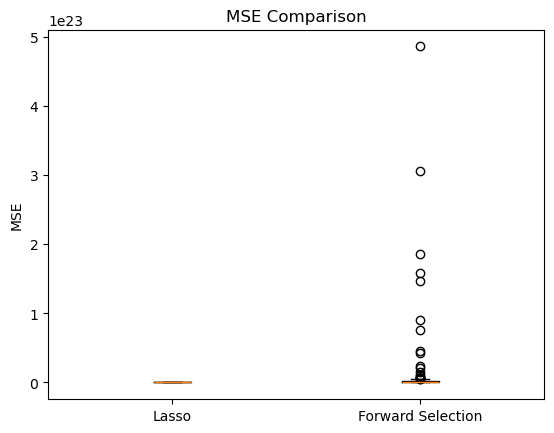

In [10]:
# Plot MSE boxplot
plt.figure()
plt.boxplot([lasso_mses, fs_mses], labels=["Lasso", "Forward Selection"])
plt.ylabel("MSE")
plt.title("MSE Comparison")
plt.show()

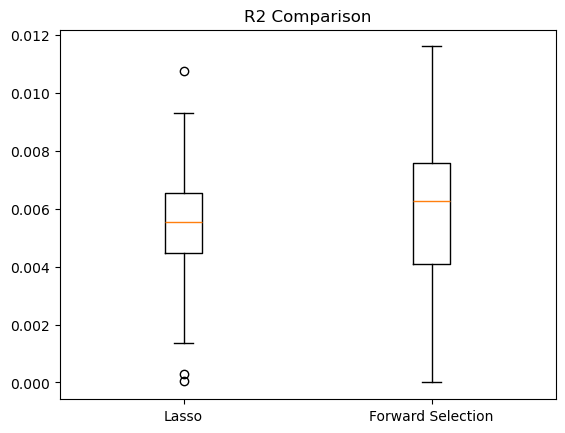

In [11]:
# Plot R2 boxplot
plt.figure()
plt.boxplot([lasso_r2s, fs_r2s])
plt.xticks([1, 2], ["Lasso", "Forward Selection"])
plt.title("R2 Comparison")
plt.show()

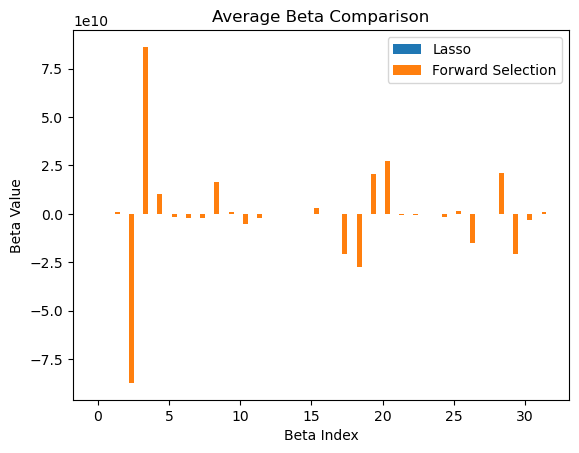

In [12]:
# Plot average betas for Lasso and Forward Selection
plt.figure()
bar_width = 0.35
index = np.arange(len(avg_lasso_betas))
plt.bar(index, avg_lasso_betas, bar_width, label="Lasso")
plt.bar(index + bar_width, avg_fs_betas, bar_width, label="Forward Selection")
plt.xlabel("Beta Index")
plt.ylabel("Beta Value")
plt.title("Average Beta Comparison")
plt.legend()
plt.show()

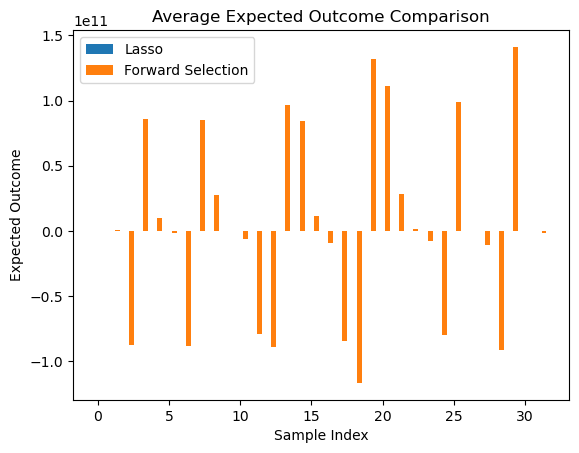

In [13]:
# Plot average expected outcomes for Lasso and Forward Selection
plt.figure()
bar_width = 0.35
index = np.arange(len(avg_lasso_expected_outcomes))
plt.bar(index, avg_lasso_expected_outcomes, bar_width, label="Lasso")
plt.bar(index + bar_width, avg_fs_expected_outcomes, bar_width, label="Forward Selection")
plt.xlabel("Sample Index")
plt.ylabel("Expected Outcome")
plt.title("Average Expected Outcome Comparison")
plt.legend()
plt.show()

### Carlson (2015)

In [14]:
base = importr('base')
utils = importr('utils')
robjects.r('install.packages("FindIt", repos="https://CRAN.R-project.org/")')

R[write to console]: trying URL 'https://CRAN.R-project.org/src/contrib/FindIt_1.2.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 150340 bytes (146 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to consol

<rpy2.rinterface_lib.sexp.NULLType object at 0x10da98550> [0]

In [15]:
findit = importr('FindIt')
robjects.r('data("Carlson", package = "FindIt")')
carlson_rdf = robjects.r['Carlson']
carlson_df = pandas2ri.rpy2py(carlson_rdf)
carlson_df.head()

,won,newRecordF,promise,coeth_voting,relevantdegree,respcodeS,contestresp
1,1,6,1,2,1,1,1.014310e+09
2,0,7,3,1,2,1,1.014310e+09
3,1,7,3,1,2,1,1.014210e+09
4,0,3,2,1,2,1,1.014210e+09
5,0,7,1,1,1,1,1.014110e+09


In [16]:
# Convert Record, Coethnicity and Degree to binary
carlson = carlson_df.iloc[:, :5].to_numpy(dtype=int)
carlson[:, 1] = np.where(carlson[:, 1] < 4, 1, 0)
carlson[:, 3:] = np.where(carlson[:, 3:] == 2, 0, 1)

In [17]:
# Convert 3 promises to 2 dummy coded categories
promises = np.zeros((carlson.shape[0], 3))
promises[np.arange(carlson.shape[0]), carlson[:, 2] - 1] = 1
carlson = np.delete(carlson, 2, axis=1)
carlson = np.insert(carlson, 2, promises[:,:2].T, axis=1)
carlson[:5]

array([[1, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 1]])

In [18]:
# Initialize factorial model
fm = FactorialModel(
    n=carlson.shape[0],
    k=carlson.shape[1] - 1,
    degree=carlson.shape[1] - 1,
    contrast_coding=True,
    beta_seed=0,
)

In [19]:
# Method to evaluate Lasso model
def evaluate_lasso(logistic=False):
    fm.convert_and_split_data(carlson[:, 1:], carlson[:, 0], is_dummy_coded=True, seed=None)
    fm.fit_lasso(logistic)     # Use logistic regression
    fm.predict()
    fm.compute_mse()

In [20]:
# Method to evaluate forward selection
def evaluate_forward_selection(T_test, y_test, logistic=False):
    fs.forward_selection(logistic)
    fs.predict(T_test)
    fs.compute_mse(y_test)

In [21]:
# Evaluate two models for NUM_TRIALS
NUM_TRIALS = 30
lasso_mses = []
fs_mses = []
lasso_betas = []
fs_betas = []
lasso_expected_outcomes = []
fs_expected_outcomes = []

for i in range(NUM_TRIALS):
    evaluate_lasso(logistic=True)
    lasso_mses.append(fm.mse)
    lasso_betas.append(fm.beta_hat)
    lasso_expected_outcomes.append(fm.expected_outcomes)

    fs = ForwardSelection(fm.T_train, fm.y_train, fm.k, strong_heredity=False)
    evaluate_forward_selection(fm.T_test, fm.y_test, logistic=True)
    fs_mses.append(fs.mse)
    fs_betas.append(fs.results.params)
    beta_mask = fm.pf.fit_transform(fm.pf.powers_)
    fs_expected_outcome = beta_mask @ fs.results.params
    fs_expected_outcomes.append(fs_expected_outcome)

Optimization terminated successfully.
         Current function value: 0.686837
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.693056
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.693056
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.693056
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.693056
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.693056
         Iterations: 3
         Function evaluations: 4
         Gradien

In [22]:
# MSE comparison
avg_lasso_mse = np.mean(np.array(lasso_mses))
avg_fs_mses = np.mean(np.array(fs_mses))
std_lasso_mse = np.std(np.array(lasso_mses))
std_fs_mses = np.std(np.array(fs_mses))
print(f"Lasso MSE: {avg_lasso_mse} +/- {std_lasso_mse}")
print(f"Forward Selection MSE: {avg_fs_mses} +/- {std_fs_mses}")

Lasso MSE: 0.46007212776919115 +/- 0.015462818326474247
Forward Selection MSE: 0.2501262709088021 +/- 0.0001291000434693782


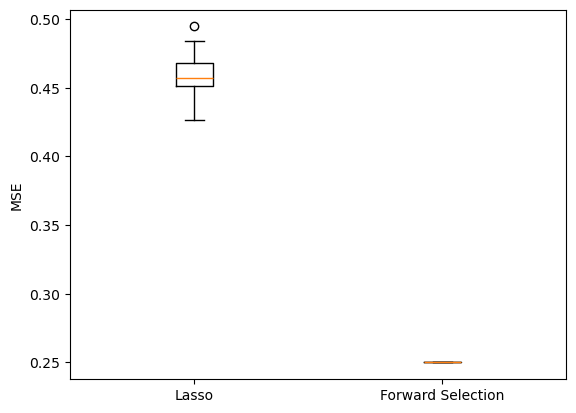

In [23]:
# Plot MSE boxplot
plt.figure()
plt.boxplot([lasso_mses, fs_mses])
plt.xticks([1, 2], ["Lasso", "Forward Selection"])
plt.ylabel("MSE")
plt.show()

### TODO: Convergence of number of observations

- Range of inputs

### Hainmueller and Hopkins (2014)